In [1]:
import stream as st, os
import anndata as ad
print(st.__version__)
st.set_figure_params(dpi=80,style='white',figsize=[5.4,4.8], rc={'image.cmap': 'viridis'})
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'stream')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files/", exist_ok=True) # will make outfiles too if they don't exist
os.makedirs(f"{out_path}/scripts", exist_ok=True)

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


1.0


In [2]:
adata = st.read('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/actb1_added/stream_traj_v5.pkl')
adata.write(f"/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/out_data/out_other_methods/stream_traj_v5.h5ad")

Working directory is already specified as '/tmp/tmptccf43nu' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


TypeError: Can't implicitly convert non-string objects to strings

Above error raised while writing key 'branch_id' of <class 'h5py._hl.group.Group'> to /

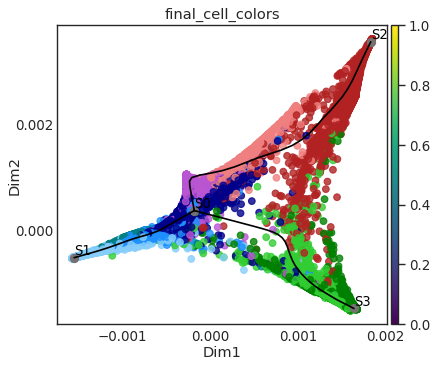

In [30]:
st.plot_dimension_reduction(adata,color=['final_cell_colors'],n_components=2,show_graph=True,show_text=True)

In [14]:
X_dr_df

,0,1
AAACAGCCAAGCCACT-3,0.001589,-0.001502
AAACAGCCAAGGTGCA-1,-0.000893,-0.000170
AAACAGCCAAGTTATC-1,-0.001197,-0.000344
AAACAGCCAATAGCCC-1,-0.001334,-0.000409
AAACAGCCAGTTAGCC-1,-0.001249,-0.000377
...,...,...
TTTGTTGGTTTACGTC-1,-0.001357,-0.000430
TTTGTTGGTTTAGTCC-1,-0.001467,-0.000481
TTTGTTGGTTTATGGG-2,-0.000381,0.000183
TTTGTTGGTTTCCTCC-3,0.001605,-0.001415


In [15]:

X_dr_df = pd.DataFrame(adata.obsm['X_dr'], index=adata.obs_names)
X_dr_df.to_csv(f"/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/out_data/out_other_methods/stream_xdr.csv")


In [8]:
adata.obsm['X_dr']

array([[ 1.58940068e-03, -1.50238371e-03],
       [-8.93352026e-04, -1.70028138e-04],
       [-1.19718032e-03, -3.44276965e-04],
       ...,
       [-3.80937178e-04,  1.83142836e-04],
       [ 1.60522860e-03, -1.41508008e-03],
       [-5.07549922e-05,  4.99996529e-04]])

In [28]:
adata.obs['label']= list(adata.obs['leiden'])
adata.uns['label_colors'] = list(adata.uns['leiden_colors'])

(-0.0017477570489247548,
 0.00201817585831157,
 -0.0017772561853961503,
 0.0038696717654162728)

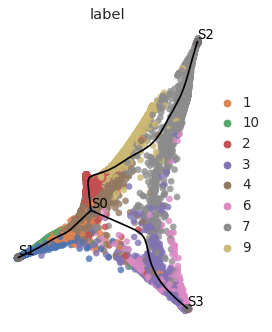

In [29]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True, color=['label'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off')

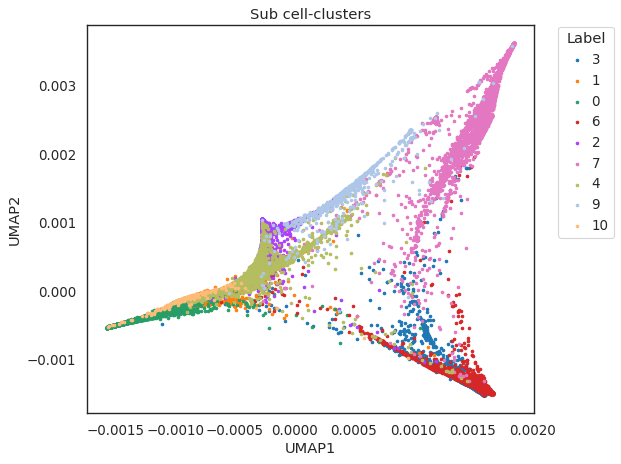

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['leiden']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = adata.uns['leiden_colors']

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points

plt.title('Sub cell-clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
adata=st.read('/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/out_other_methods/adata_aggregated_peak.leiden.h5ad')
# basic sanity check
# (adata.X.A == adata.layers['counts'].A).all()
# adata.X = adata.X.toarray() # required for stream

Using default working directory.
Saving results in: /ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/notebooks/stream_result


In [26]:
np.sum(adata.X,axis=0).A1.astype(int).shape

(191255,)

In [29]:
import numpy as np
from scipy.sparse import csr_matrix
import re

def cal_qc(adata, expr_cutoff=1, assay='rna'):
    assay = assay.lower()
    assert assay in ['rna', 'atac'], "`assay` must be chosen from ['rna', 'atac']"

    # Compute column-wise (features) sum
    n_counts = np.array(adata.X.sum(axis=0)).flatten().astype(int)
    adata.var['n_counts'] = n_counts

    # Compute the number of cells expressing each feature
    n_cells = np.array((adata.X >= expr_cutoff).sum(axis=0)).flatten().astype(int)
    adata.var['n_cells'] = n_cells
    adata.var['pct_cells'] = n_cells / adata.shape[0]

    # Compute row-wise (cells) sum
    n_counts = np.array(adata.X.sum(axis=1)).flatten().astype(int)
    adata.obs['n_counts'] = n_counts

    # Compute the number of features expressed in each cell
    n_features = np.array((adata.X >= expr_cutoff).sum(axis=1)).flatten().astype(int)

    if assay == 'atac':
        adata.obs['n_peaks'] = n_features
        adata.obs['pct_peaks'] = n_features / adata.shape[1]
    elif assay == 'rna':
        adata.obs['n_genes'] = n_features
        adata.obs['pct_genes'] = n_features / adata.shape[1]
        
        # Identify mitochondrial genes
        r = re.compile("^MT-", flags=re.IGNORECASE)
        mt_genes = list(filter(r.match, adata.var_names))
        if len(mt_genes) > 0:
            n_counts_mt = np.array(adata[:, mt_genes].X.sum(axis=1)).flatten().astype(int)
            adata.obs['pct_mt'] = n_counts_mt / n_counts
        else:
            adata.obs['pct_mt'] = 0

    adata.uns['assay'] = assay
    return None


/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/stream/core.py:507: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sc_i1 = sns.distplot(df_obs[ann],vertical=True)
/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/stream/core.py:507: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4414

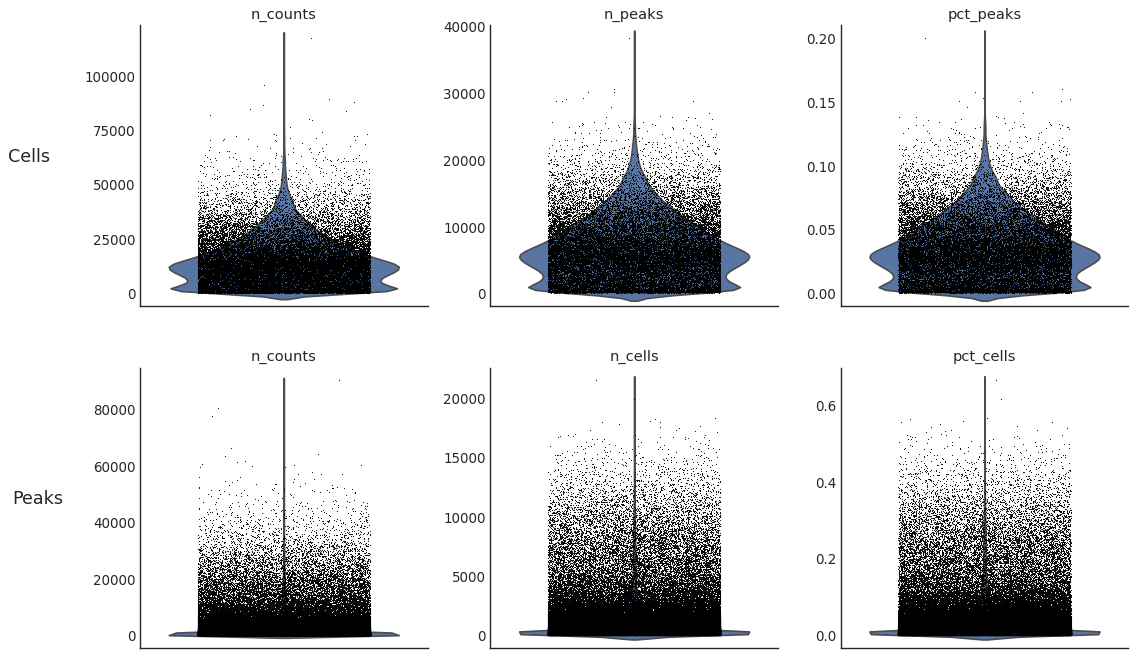

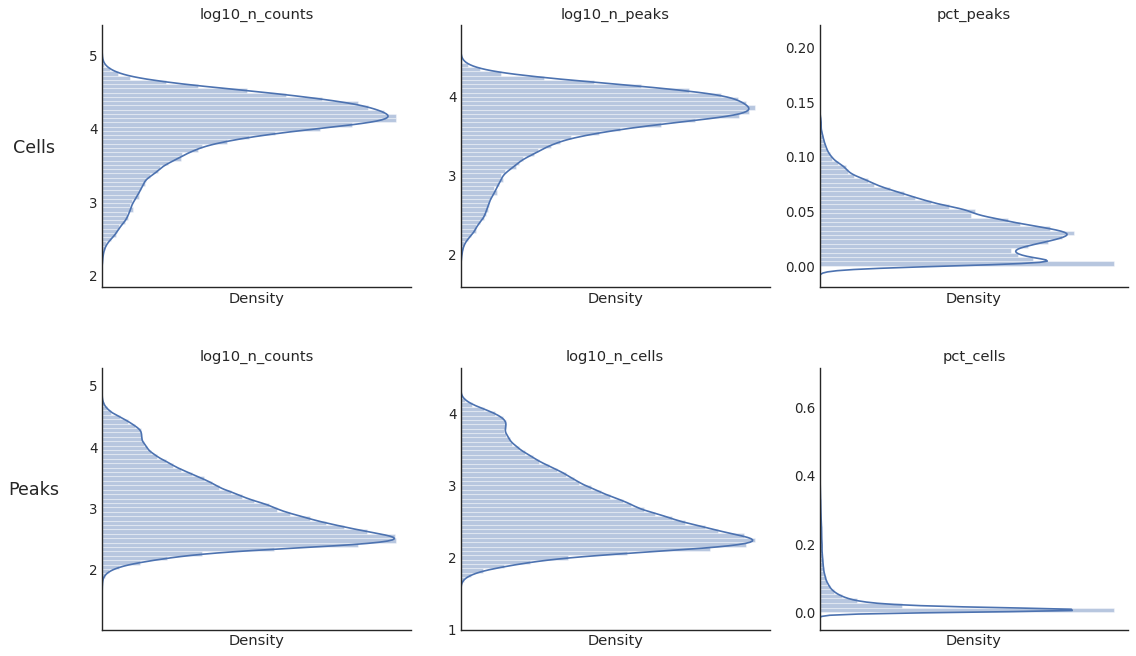

In [30]:
cal_qc(adata,assay='atac')
st.plot_qc(adata,jitter=0.3)
st.plot_qc(adata,log_scale=[0,1,3,4],hist_plot=range(6),jitter=0.3)

In [31]:
st.filter_cells(adata,min_n_features=100)
st.filter_features(adata,min_n_cells=20)

filter cells based on min_n_features
after filtering out low-quality cells: 
32408 cells, 191255 peaks
Filter peaks based on min_n_cells
After filtering out low-expressed peaks: 
32408 cells, 191254 peaks


#### LSI transformation

In [32]:
adata.X[adata.X>0] = 1 ###binarization
st.normalize(adata,method='tf_idf')

#### Feature selection

In [59]:
st.select_top_principal_components(adata,first_pc=False,n_pc=50,feature='X_joint_umap_features')

ValueError: unrecognized feature 'X_joint_umap_features'

#### Dimension reduction

In [34]:
adata

AnnData object with n_obs × n_vars = 32408 × 191254
    obs: 'cell_type_major', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'cell_index', 'leiden_joint', 'n_counts', 'n_peaks', 'pct_peaks'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'n_cells', 'pct_cells'
    uns: 'topic_dendogram', 'workdir', 'assay'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap_features'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'

In [81]:
st.dimension_reduction(adata,method='lsi',feature='top_pcs',n_components=5,n_neighbors=100,n_jobs=os.cpu_count())

ValueError: unrecognized method 'lsi'

In [60]:
adata

AnnData object with n_obs × n_vars = 32408 × 191254
    obs: 'cell_type_major', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'cell_index', 'leiden_joint', 'n_counts', 'n_peaks', 'pct_peaks'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'n_cells', 'pct_cells'
    uns: 'topic_dendogram', 'workdir', 'assay'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap_features', 'X_dr'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'

In [50]:
import scanpy as sc

In [74]:
adata.obsm['X_umap'] = adata.obsm['X_joint_umap_features']
adata.obs['label'] = adata.obs['leiden_joint'].apply(lambda x: adata.uns['leiden_joint_colors'][int(x)])

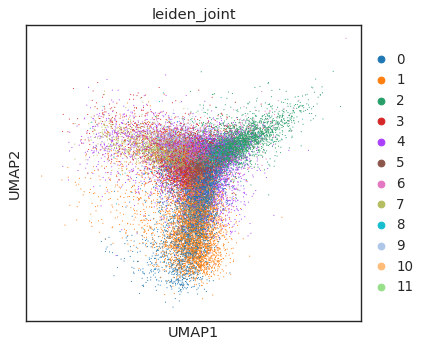

In [62]:
sc.pl.umap(adata, color='leiden_joint')

In [71]:
adata.uns['leiden_joint_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a']

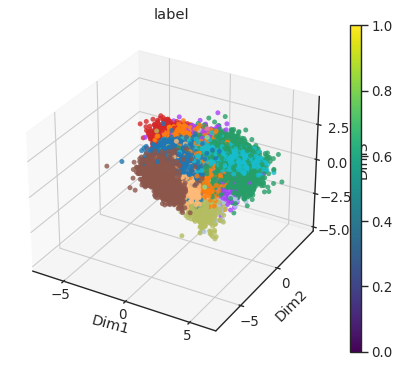

In [75]:
st.plot_dimension_reduction(adata,show_graph=False,show_text=False,)

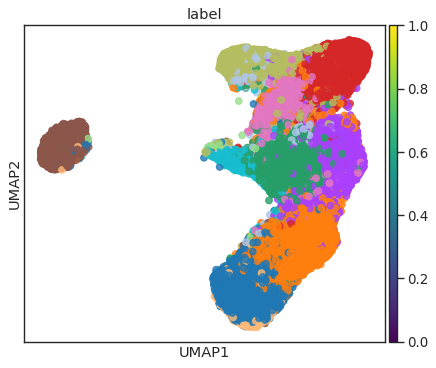

In [76]:
st.plot_visualization_2D(adata,n_neighbors=100,use_precomputed=False)

#### Trajectory inference

* By default, trajectories will be inferred in **the manifold learnt from the step of dimension reduction `st.dimension_reduction()`**


* But it can be also learned directly on **2D visualization plot from `st.plot_visualization_2D()`** by setting `use_vis=True` in st.seed_elastic_principal_graph(). An example can be found [here](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.2.use_vis.ipynb)

In [78]:
st.seed_elastic_principal_graph(adata,n_clusters=10, use_vis=True)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...


AttributeError: 'Graph' object has no attribute 'node'

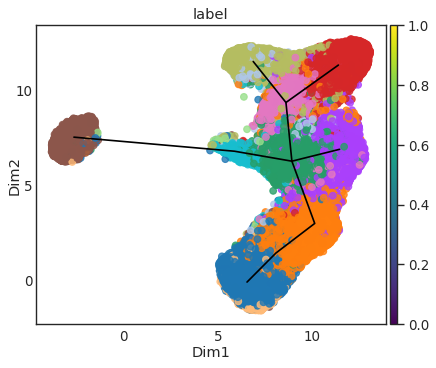

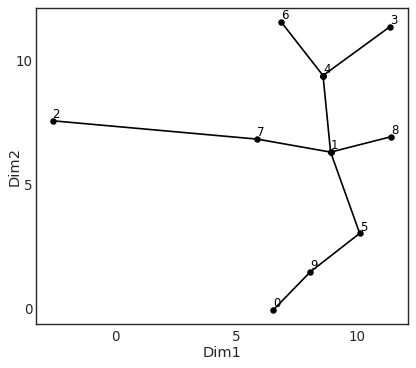

In [79]:
st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)

**`epg_alpha`, `epg_mu`, `epg_lambda` are the three most influential parameters for learning elastic principal graph.**  
- `epg_alpha`: penalizes spurious branching events. **The larger, the fewer branches the function will learn**. (by default, `epg_alpha=0.02`)
- `epg_mu`: penalizes the deviation from harmonic embedding, where harmonicity assumes that each node is the mean of its neighbor nodes. **The larger, the more edges the function will use to fit into points(cells)** (by default, `epg_mu=0.1`) 
- `epg_lambda`: penalizes the total length of edges. **The larger, the 'shorter' curves the function will use to fit into points(cells)** and the fewer points(cells) the curves will reach. (by default, `epg_lambda=0.02`)

> **'epg_trimmingradius'** can help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.elastic_principal_graph(adata,epg_trimmingradius=0.1)`  

In [80]:
st.elastic_principal_graph(adata,epg_alpha=0.01,epg_mu=0.05,epg_lambda=0.01)

Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 32408 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

3||50
	
0.8272
	
50
	
49
	
42
	
3
	
0
	
0
	
0.4962
	
0.46
	
0.9837
	
0.9849
	
0.2801
	
0.05095
	
2.548
	
127.4
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


66.535 sec elapsed

[[1]]





AttributeError: 'Graph' object has no attribute 'node'

Importing precomputed umap visualization ...


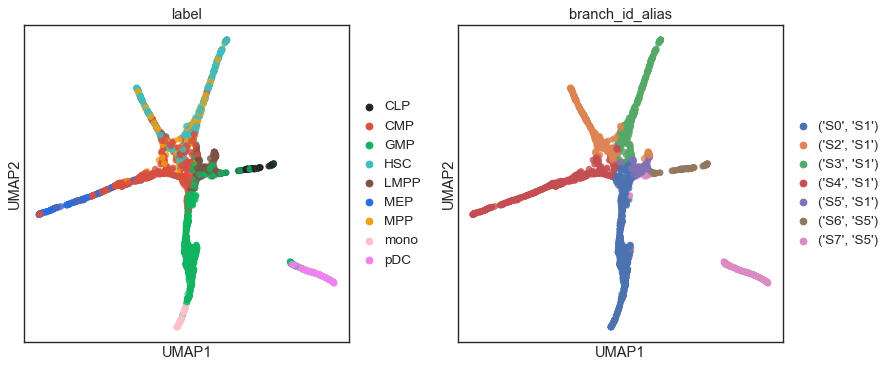

In [21]:
st.plot_visualization_2D(adata,n_neighbors=30,color=['label','branch_id_alias'],fig_ncol=4)

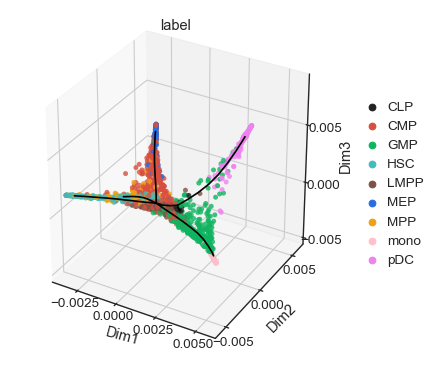

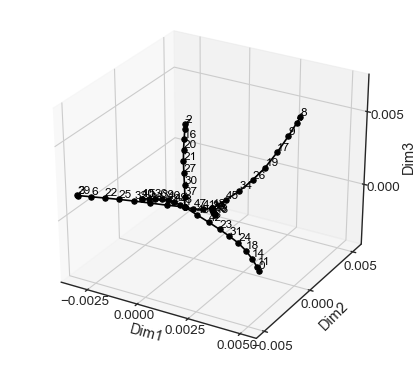

In [22]:
st.plot_dimension_reduction(adata,color=['label'],show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)

Extending leaves with additional nodes ...
Number of branches after extending leaves: 7


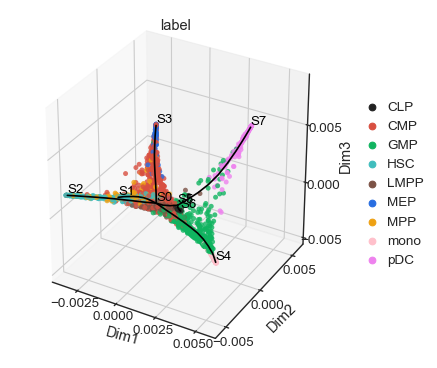

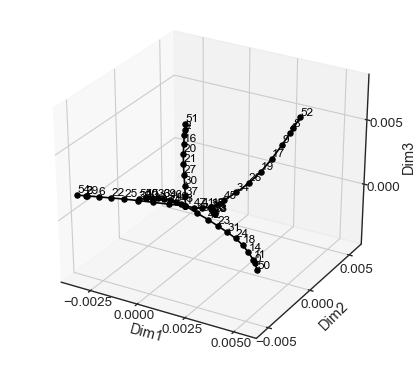

In [23]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['label'],show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

#### Trajectory visualization

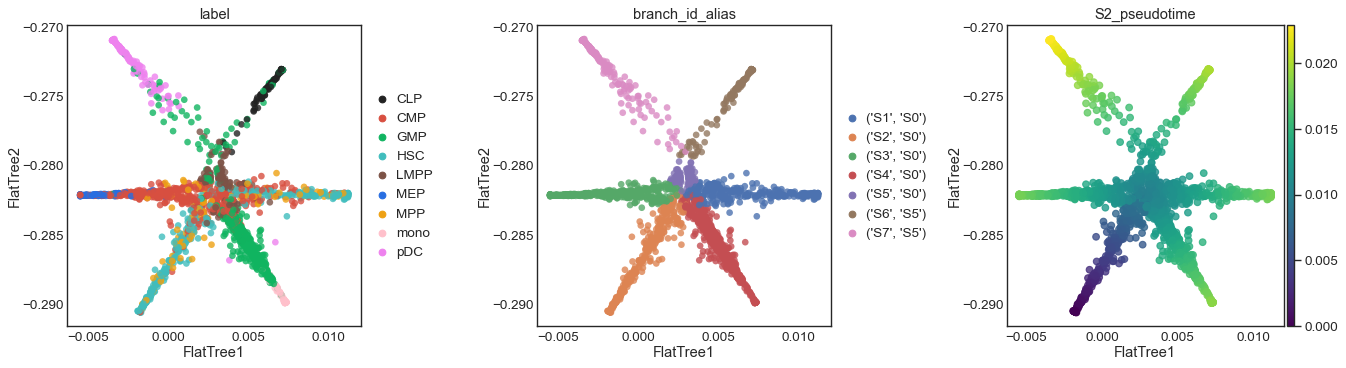

In [24]:
st.plot_flat_tree(adata,color=['label','branch_id_alias','S2_pseudotime'],
                  dist_scale=0.5,show_graph=False,show_text=False)

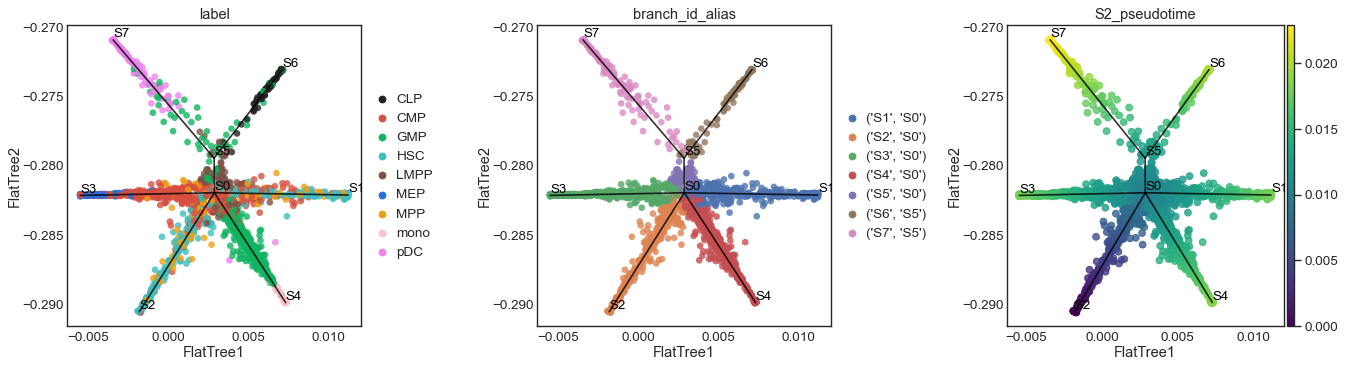

In [25]:
st.plot_flat_tree(adata,color=['label','branch_id_alias','S2_pseudotime'],
                  dist_scale=0.5,show_graph=True,show_text=True)

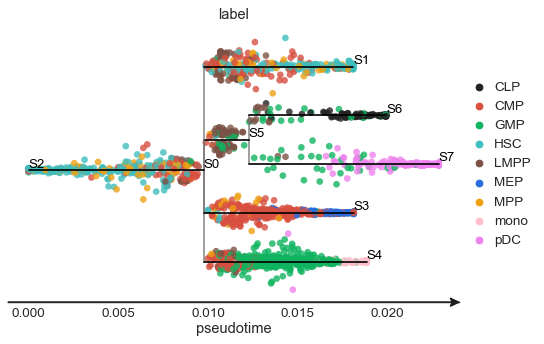

In [26]:
st.plot_stream_sc(adata,root='S2',color=['label'],
                  dist_scale=0.5,show_graph=True,show_text=True)

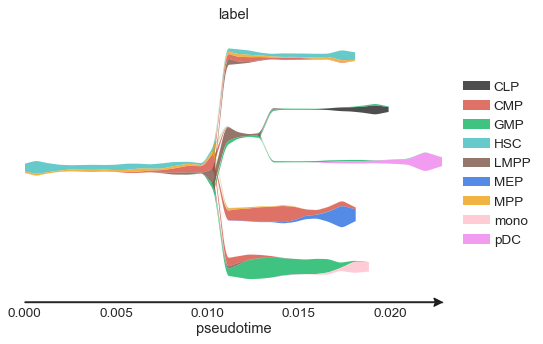

In [27]:
st.plot_stream(adata,root='S2',color=['label'])

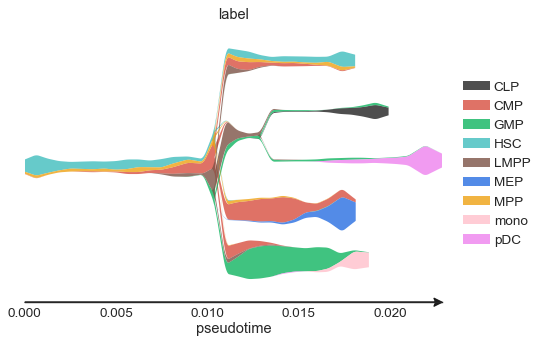

In [28]:
st.plot_stream(adata,root='S2',color=['label'],dist_scale=1.5)

#### Marker peaks detection

In [39]:
st.detect_leaf_markers(adata,marker_list=adata.var[adata.var['pct_cells']>0.1].index[:1000],
                       cutoff_zscore=1.0,cutoff_pvalue=0.01,
                       root='S1',n_jobs=4)

Scanning the specified marker list ...
Filtering out markers that are expressed in less than 5 cells ...
4 cpus are being used ...
1000 markers are being scanned ...


In [40]:
adata.uns['leaf_markers_all'].head()

,zscore,H_statistic,H_pvalue,S1S0_pvalue,S0S2_pvalue,S5S6_pvalue,S5S7_pvalue,S0S3_pvalue,S0S4_pvalue
chr1_153316244_153316744,1.99543,208.943,3.46483e-43,7.50054e-16,6.0345e-13,1.55844e-17,5.79801e-24,1,2.31817e-39
chr1_22192536_22193036,2.11995,208.23,4.92492e-43,3.18796e-37,5.91293e-40,1.49564e-24,1,2.71929e-26,1.44069e-24
chr1_43429184_43429684,1.91797,182.744,1.38784e-37,2.50462e-19,8.47747e-10,7.2495e-14,4.73132e-08,1,1.13027e-37
chr1_21620867_21621367,2.00705,175.209,5.64079e-36,3.03839e-27,1.72508e-20,1.82425e-10,1,3.08267e-34,5.81846e-14
chr1_59221069_59221569,1.9805,172.563,2.07057e-35,7.72735e-12,1,8.15814e-20,3.42885e-25,2.75201e-23,9.65561e-25


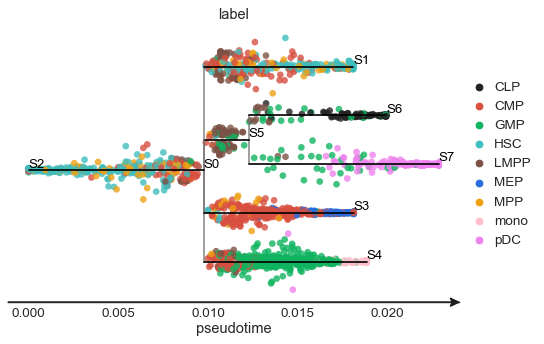

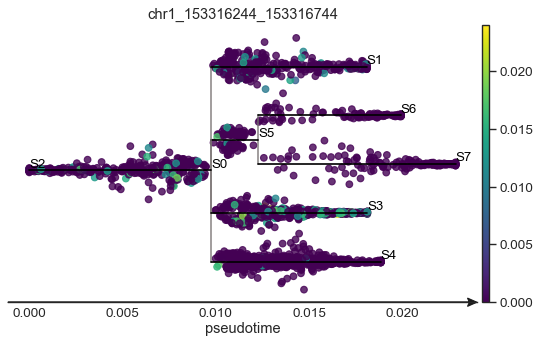

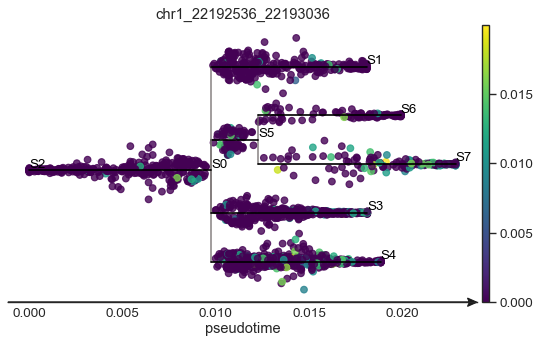

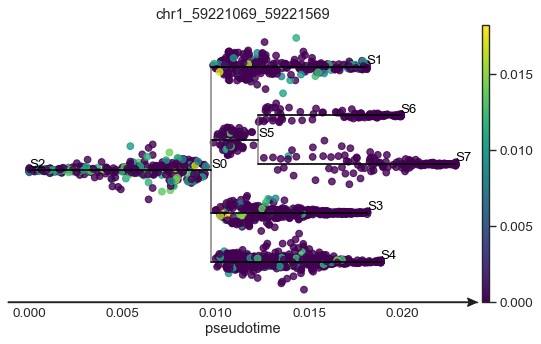

In [42]:
st.plot_stream_sc(adata,root='S2',color=['label','chr1_153316244_153316744','chr1_22192536_22193036','chr1_59221069_59221569'],
                  dist_scale=0.5,show_graph=True,show_text=True)

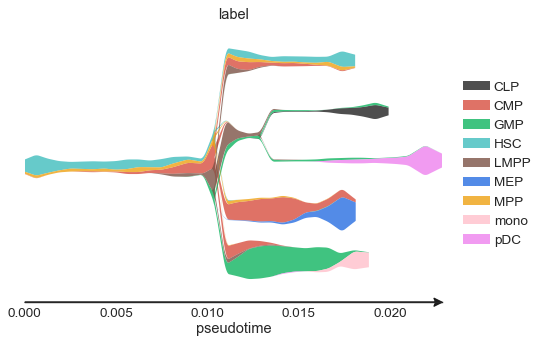

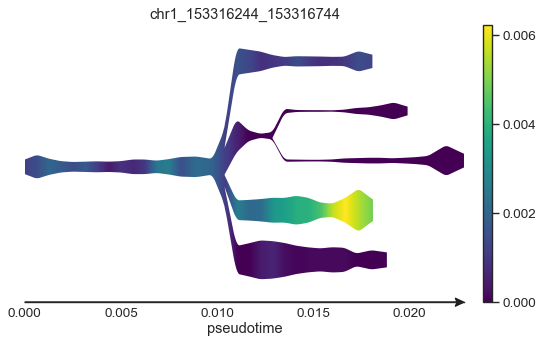

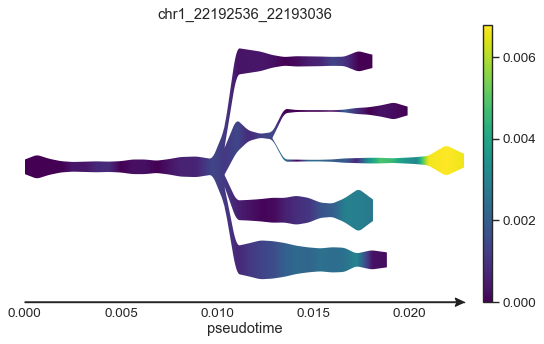

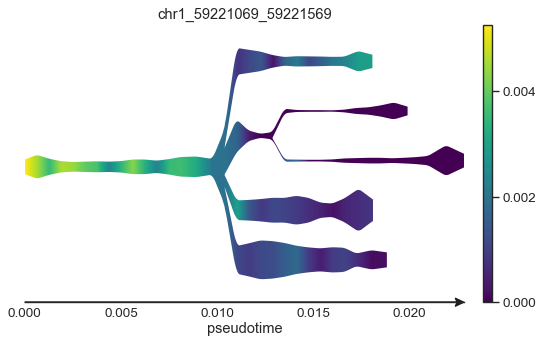

In [43]:
st.plot_stream(adata,root='S2',color=['label','chr1_153316244_153316744','chr1_22192536_22193036','chr1_59221069_59221569'],
               dist_scale=1.5)

#### Save results

In [44]:
st.write(adata,file_name='stream_atac_peaks.pkl')